In [103]:
import time
from datetime import datetime
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## Описание задачи:
плашка

Для прогнозирования временных рядов цен на медь можно выбрать различные метрики оценки точности модели. RMSE (Root Mean Squared Error) и MAE (Mean Absolute Error) являются двумя из самых популярных метрик для этой задачи.

RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны.

Выбор между RMSE и MAE зависит от конкретной задачи и предпочтений аналитика. Если вам важны большие ошибки и вы хотите избежать их, то RMSE может быть более подходящей метрикой. Если вам важна общая ошибка без учета направления, то MAE может быть предпочтительнее.

В конечном счете, рекомендуется провести сравнительный анализ результатов, используя обе метрики, чтобы определить, какая из них лучше соответствует вашим потребностям и целям прогнозирования.

плашка

плашка

плашка

---

## Технический блок.

## Содержание:
### - Парсер
### - Функция проверки стационарности ряда

### В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

#### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [104]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [105]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'
    
    return result_row

In [106]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock_aluminium.csv', 'a') as file:
                file.write(metric)

        
def log_metrics_spot(metric):
    with open('./data/errors/spot_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot_aluminium.csv', 'a') as file:
                file.write(metric)


In [107]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

---

## Часть 0.

### Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [108]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/aluminium.csv', parse_dates=['date'], index_col=['date'])

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3973.000000,3973.000000,3973.000000
mean,2046.456456,2008.813365,2739.783262
std,412.256416,485.502802,1741.181077
min,0.000000,0.000000,0.000000
25%,1761.000000,1778.000000,1150.875000
50%,1975.000000,1972.000000,2195.375000
75%,2260.500000,2252.500000,4564.975000
max,3984.500000,3968.000000,5492.325000


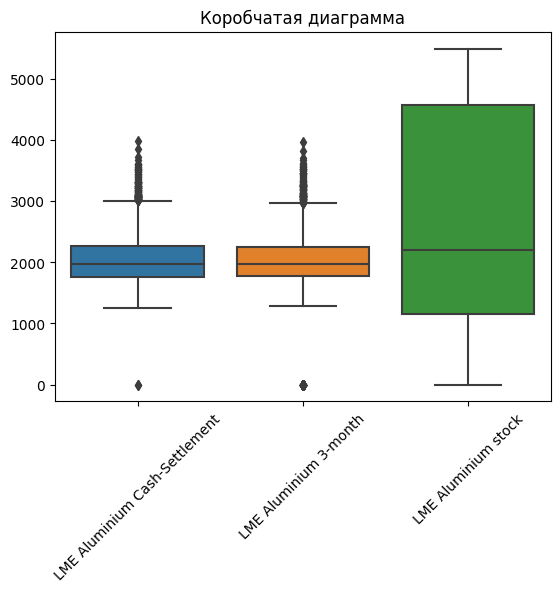

In [109]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3889.000000,3889.000000,3889.000000
mean,2029.057213,2051.699537,2775.995082
std,393.011052,390.921903,1740.619251
min,1253.500000,1288.500000,271.450000
25%,1756.000000,1787.000000,1186.075000
50%,1964.500000,1983.000000,2248.875000
75%,2237.500000,2262.000000,4569.125000
max,3984.500000,3968.000000,5492.325000


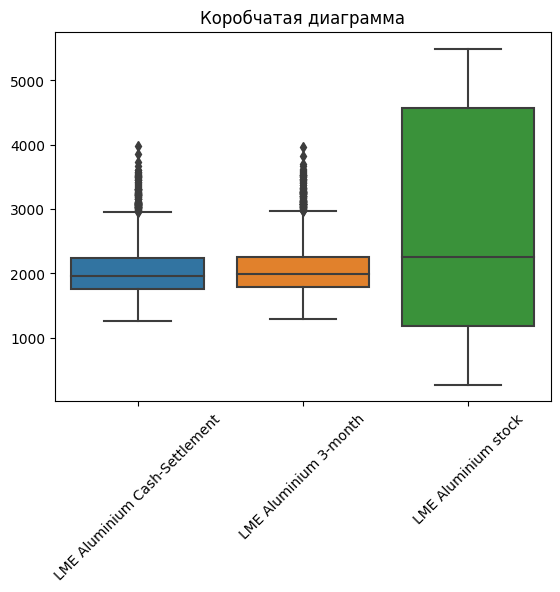

In [110]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

In [111]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [112]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Aluminium 3-month'] = data['LME Aluminium 3-month'].shift(90)

# Обрежем 13 год, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
365,2009-01-01,1473.500000,2301.000000,2333.600000
366,2009-01-02,1492.000000,2285.666667,2338.300000
367,2009-01-03,1499.833333,2270.333333,2340.608333
368,2009-01-04,1507.666667,2255.000000,2342.916667
369,2009-01-05,1515.500000,2275.000000,2345.225000


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
85,2023-12-12,NaN,2235.0,NaN
86,2023-12-13,NaN,2197.0,NaN
87,2023-12-14,NaN,2200.0,NaN
88,2023-12-15,NaN,2203.0,NaN
89,2023-12-16,NaN,2206.0,NaN


Диапазон планирования равен 90 дней


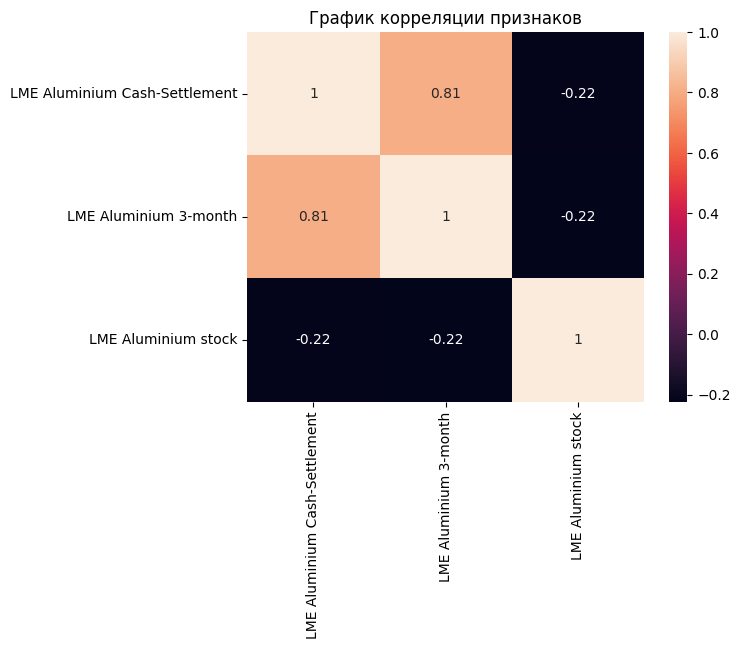

In [113]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data['LME Aluminium stock'].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data['LME Aluminium stock'].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

#### Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.
#### Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.
#### Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

## Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [114]:
# Будем прогнозировать временной ряд LME Copper stock и 
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data['LME Aluminium stock']
spot = working_data['LME Aluminium Cash-Settlement']

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

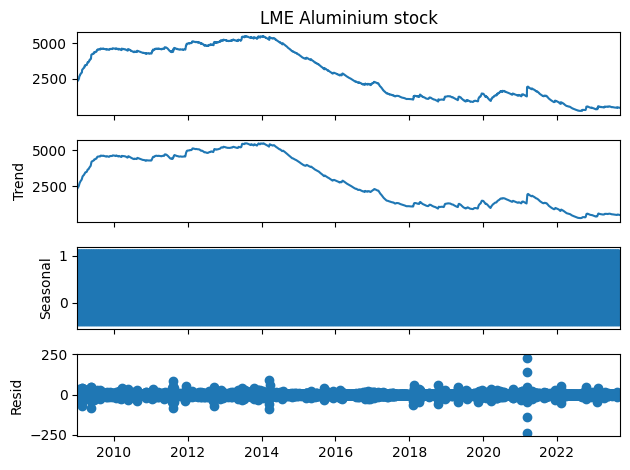

In [115]:
decompose_stock.plot()
plt.show()

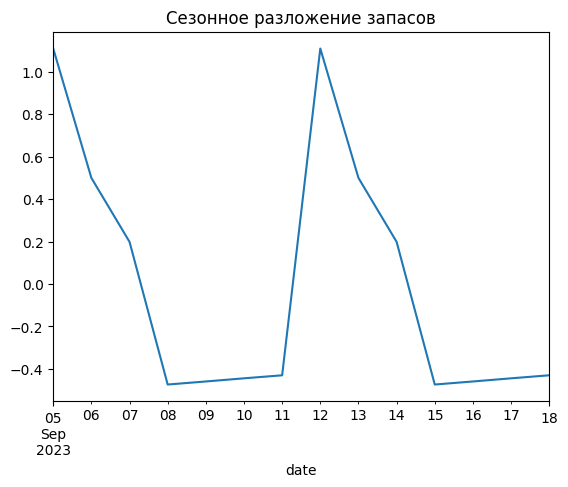

In [116]:
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

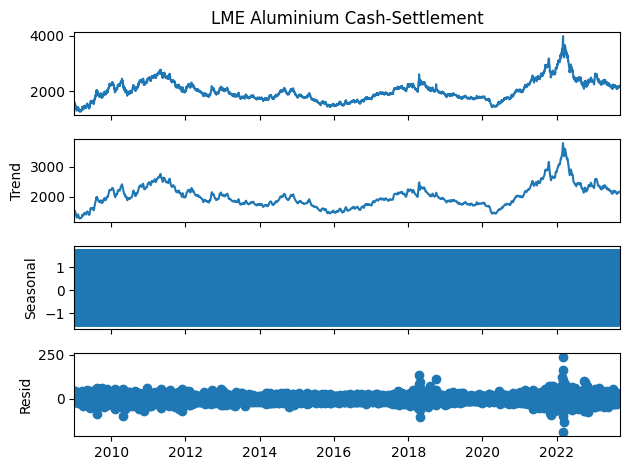

In [117]:
decompose_spot.plot()
plt.show()

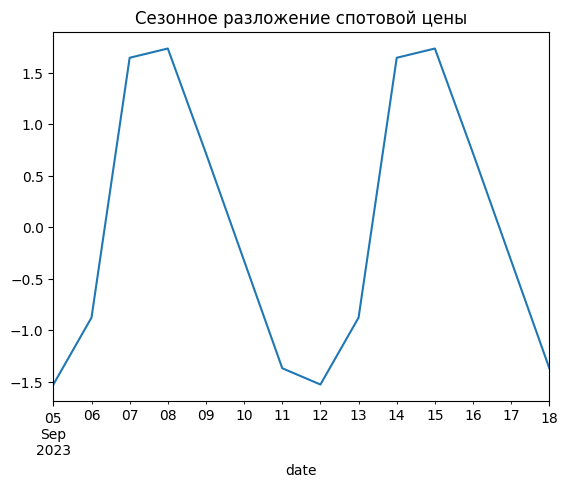

In [118]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -10.201306106396627, 'crit_value (5%)': -2.8620809980711943}
Единичных корней нет, ряд стационарен
{'p_value': -22.900491493920118, 'crit_value (5%)': -2.862079282068866}


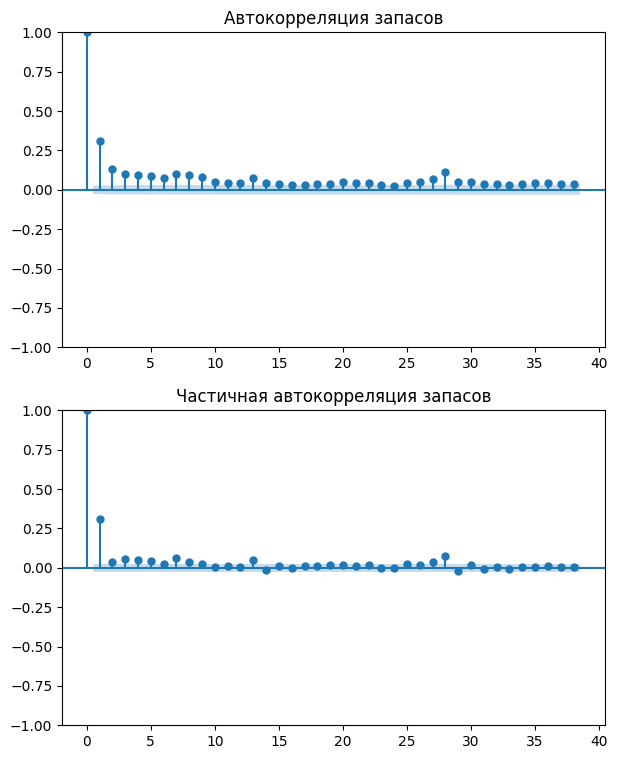

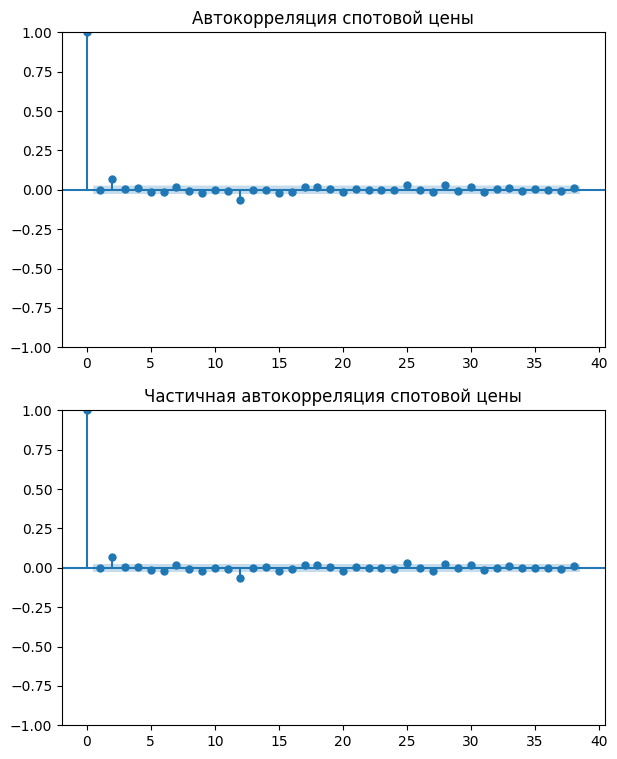

In [119]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 1 (так же исходя из pacf)

In [120]:
p_stock = 1
d_stock = 1
q_stock = 0

p_spot = 2
d_spot = 1
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [121]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [122]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [123]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [124]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 16.607
MAE для AR-baseline-stock: 14.04
MAPE для AR-baseline-stock: 2.8000000000000003%


Дубликат значения metric. Не сохраняем.
RMSE для AR-baseline-spot: 49.11
MAE для AR-baseline-spot: 39.343
MAPE для AR-baseline-spot: 1.9%


Дубликат значения metric. Не сохраняем.


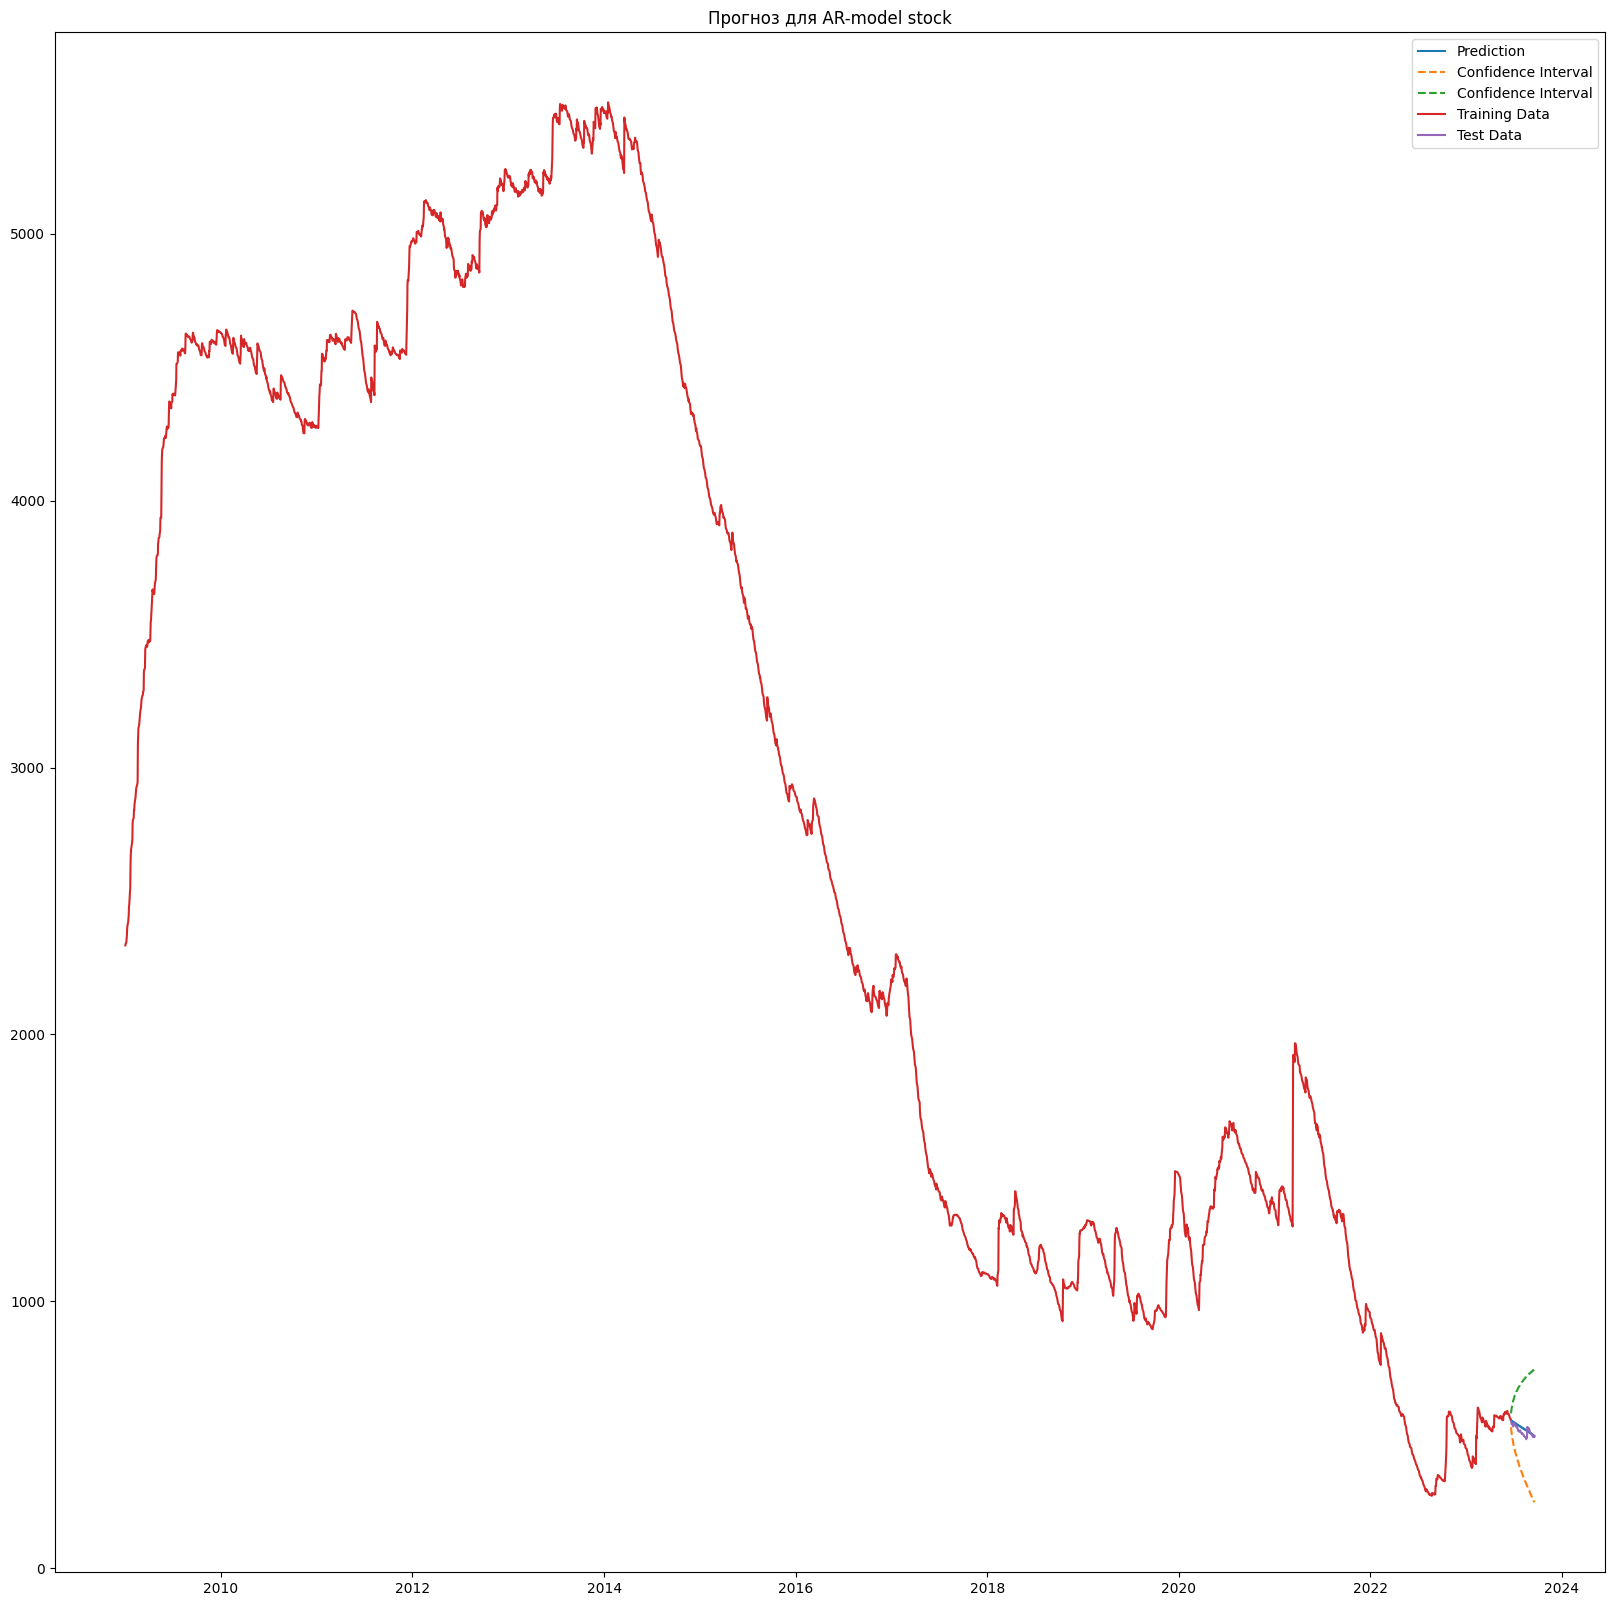

In [125]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

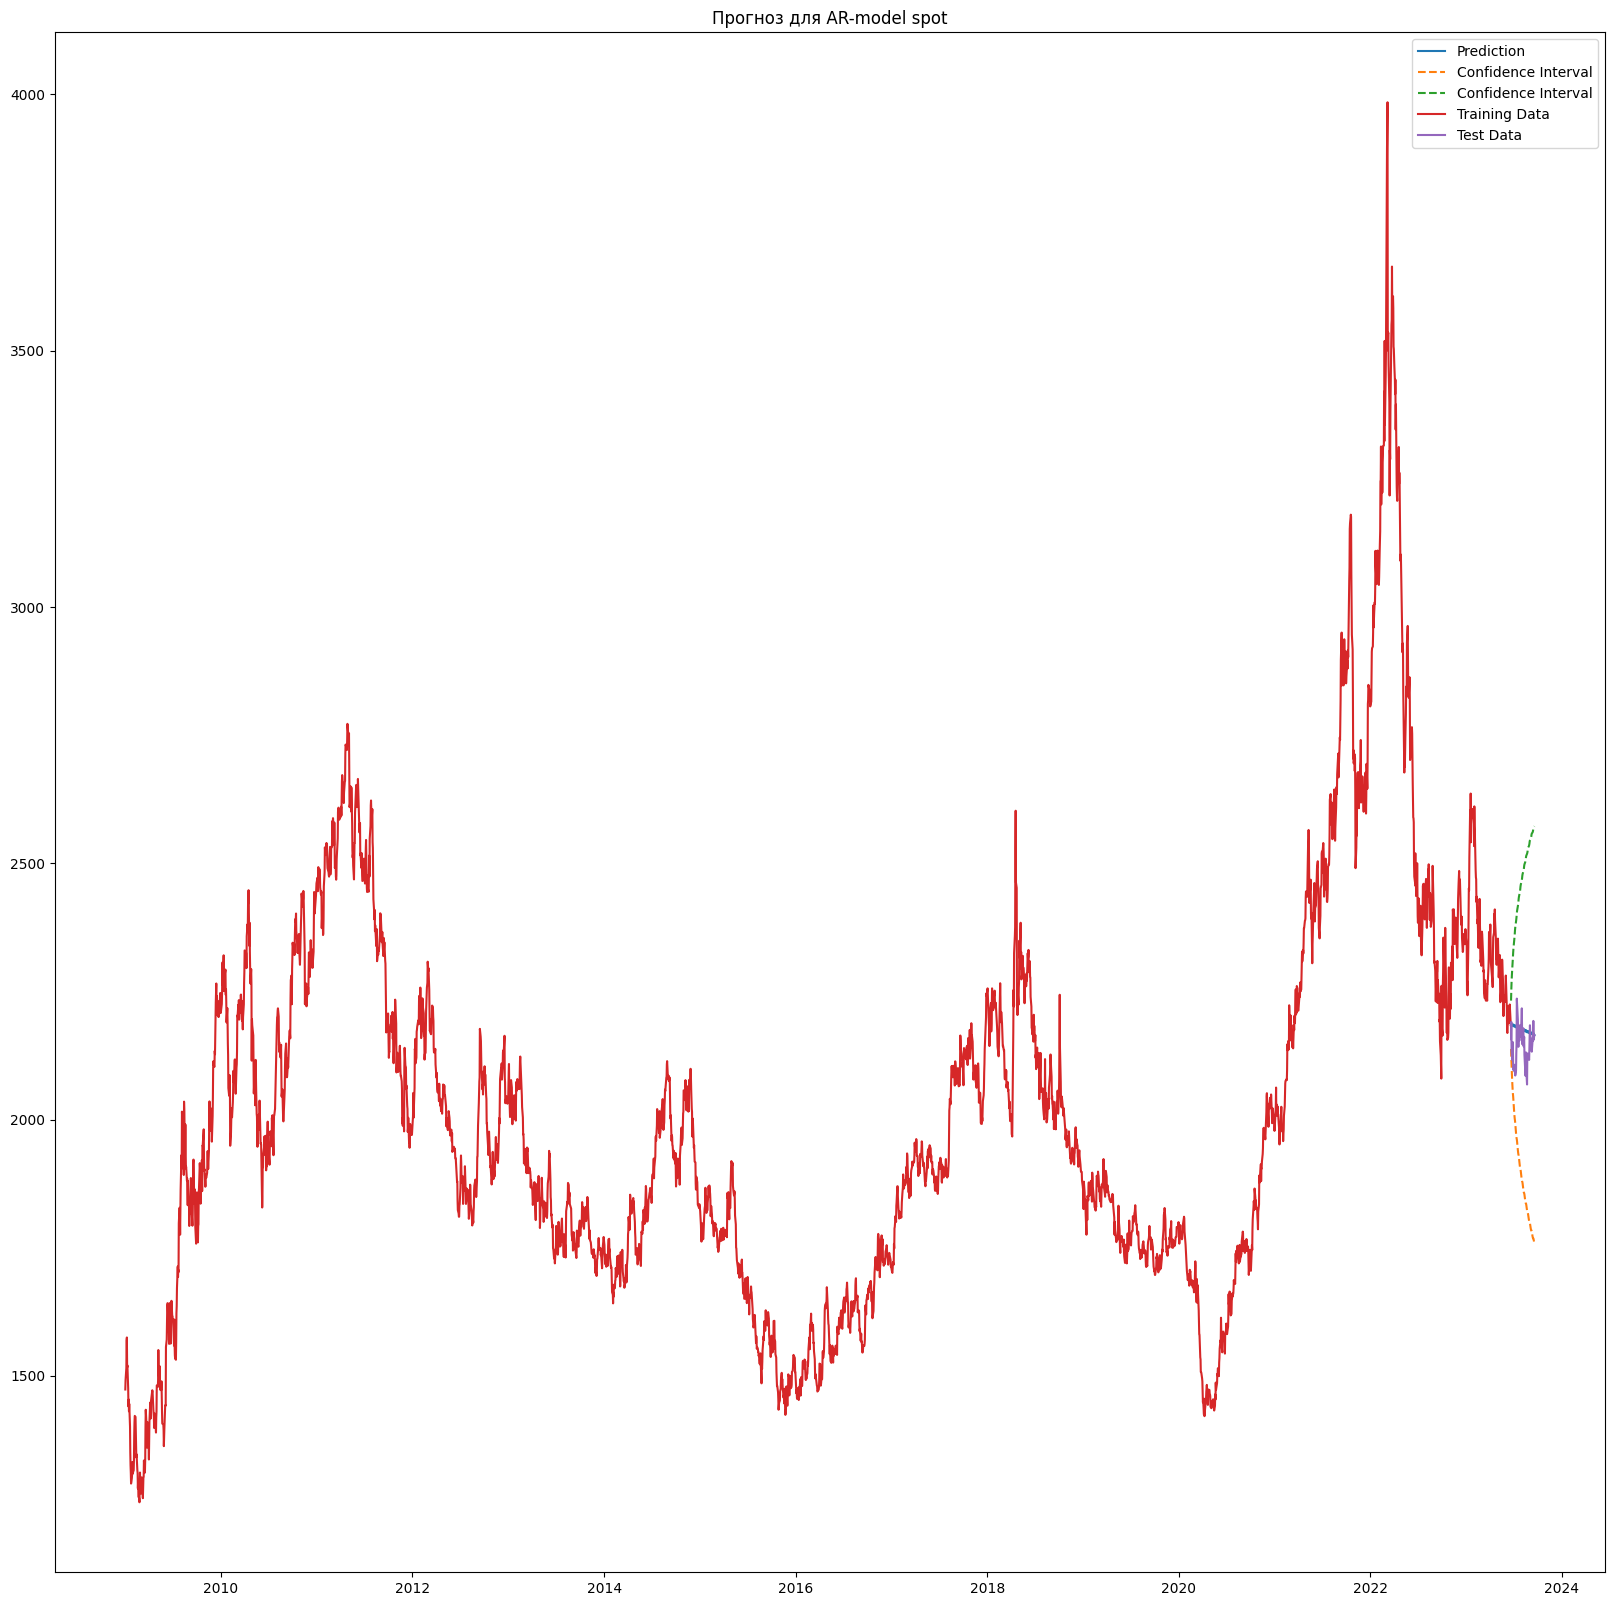

In [126]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьмаширок
> Что говорит о вероято слабой прогностической способности в бою.

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1 - d=1)

In [127]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [128]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 43.35
MAE для ARIMA-stock: 39.507
MAPE для ARIMA-stock: 7.8%


Дубликат значения metric. Не сохраняем.
RMSE для ARIMA-spot: 53.761
MAE для ARIMA-spot: 45.099
MAPE для ARIMA-spot: 2.1%


Дубликат значения metric. Не сохраняем.


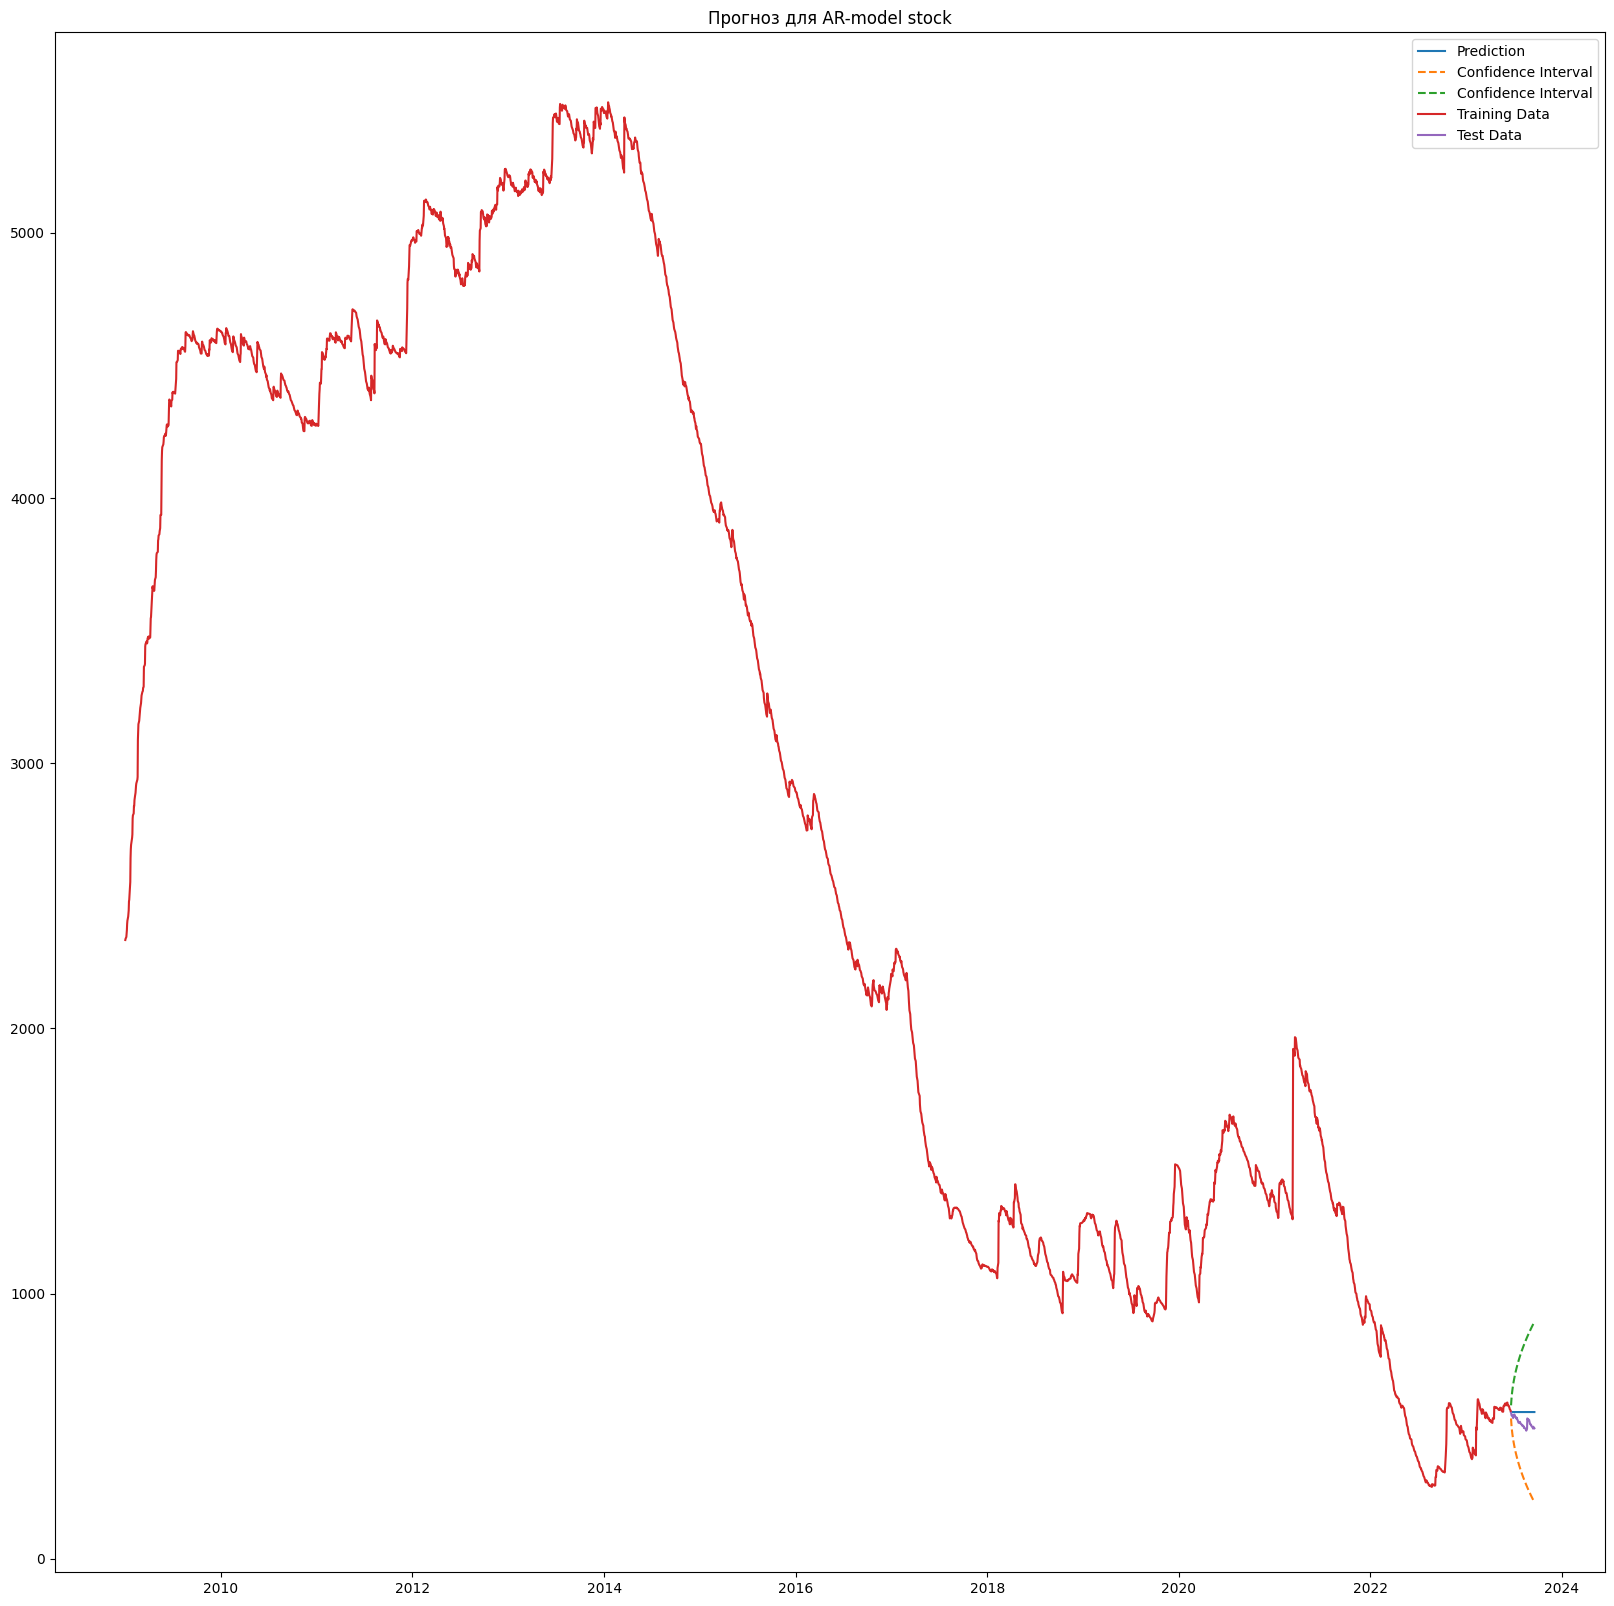

In [129]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

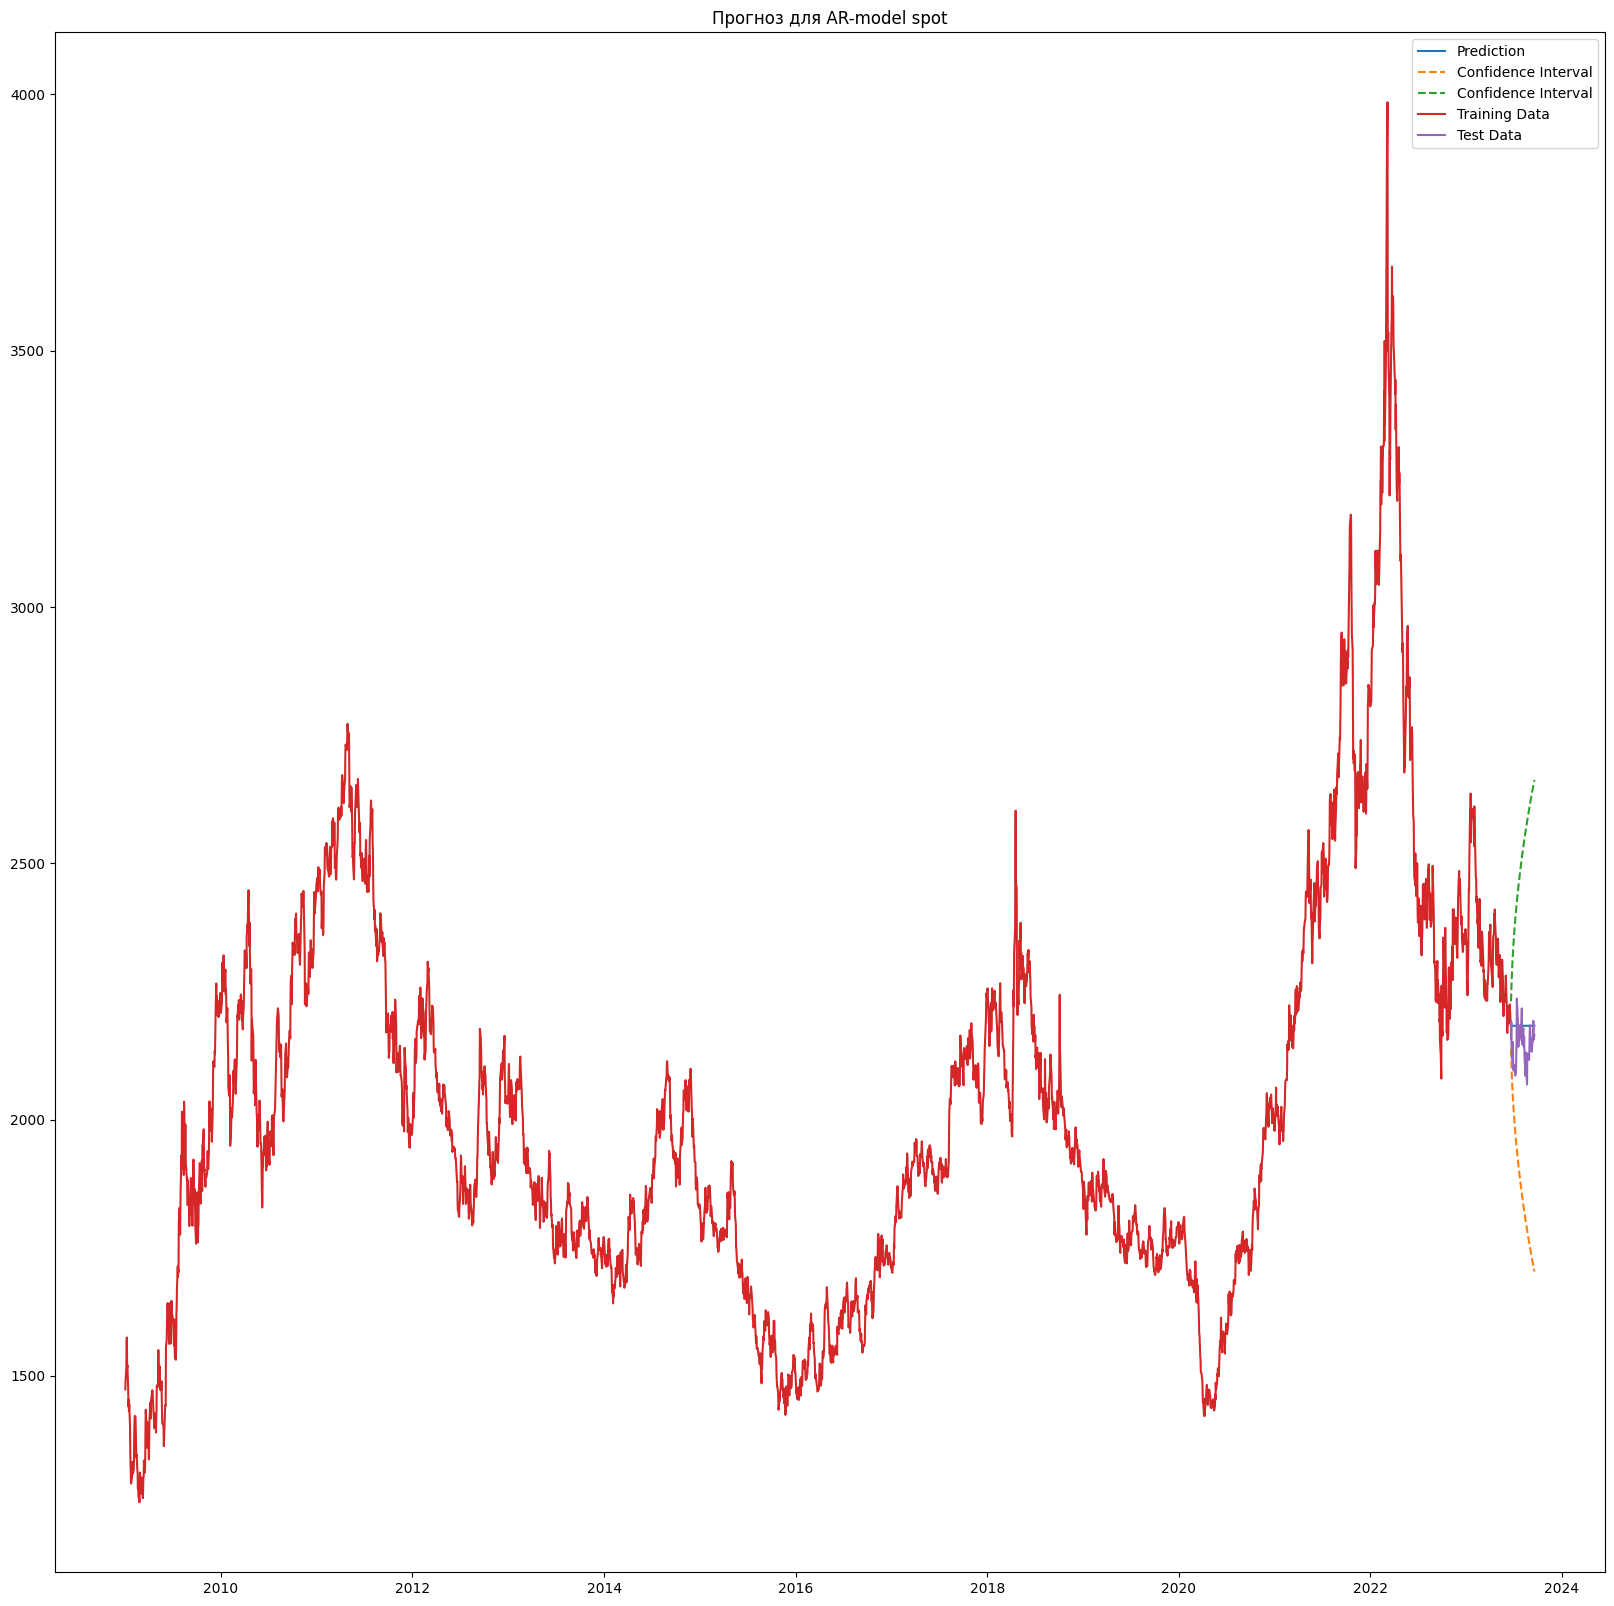

In [130]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [131]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.10 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=45402.840, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=43737.196, Time=1.42 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.75 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=45061.341, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43127.167, Time=2.62 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.07 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=43511.902, Time=1.05 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=43127.541, Time=1.74 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=43126.939, Time=1.93 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=43737.748, Time=0.87 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=inf, Time=7.83 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=43158.150, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5284
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -21554.095
Date:                           Tue, 19 Sep 2023   AIC                          43122.191
Time:                                   17:44:31   BIC                          43168.187
Sample:                               01-01-2009   HQIC                         43138.268
                                    - 06-20-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2599      0.003    100.285      0.000       0.255       0.265
ar.L2          0.0084      0.007      1.289      0.197      -0.004       0.021
ar.L3          0.0284      0.016      1.759      0.079      -0.003       0.060
ar.L4          0.0240      0.016      1.511      0.131      -0.007       0.055
ar.S.L7       -0.6302      0.003   -191.749      0.000      -0.637      -0.624
ar.S.L14      -0.3323      0.003   -100.493      0.000      -0.339      -0.326
sigma2       206.8706      0.602    343.613      0.000     205.691     208.051
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2207193.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             5.43
Prob(H) (two-sided):                  0.10   Kurtosis:                       102.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=52133.174, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=50684.522, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.49 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=52134.598, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=50054.293, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.13 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=50052.555, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=50683.061, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=6.74 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=50054.331, Time=1.51 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=50047.713, Time=2.30 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=50673.687, Time=1.25 sec
 ARIMA(1,1,1)(2,1,1)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5284
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -25003.895
Date:                           Tue, 19 Sep 2023   AIC                          50017.790
Time:                                   17:45:49   BIC                          50050.645
Sample:                               01-01-2009   HQIC                         50029.274
                                    - 06-20-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0065      0.009      0.743      0.458      -0.011       0.024
ar.L2          0.0854      0.009      9.497      0.000       0.068       0.103
ar.S.L7       -0.6563      0.006   -106.143      0.000      -0.668      -0.644
ar.S.L14      -0.3324      0.005    -65.615      0.000      -0.342      -0.322
sigma2       764.9461      4.408    173.544      0.000     756.307     773.585
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            179813.54
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [134]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### SARIMAX

In [135]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [136]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы 
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10997D+00    |proj g|=  2.02077D-02

At iterate    5    f=  4.08785D+00    |proj g|=  7.47709D-02

At iterate   10    f=  4.07913D+00    |proj g|=  5.12006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     15      1     0     0   7.034D-06   4.079D+00
  F =   4.0791247969023621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76633D+00    |proj g|=  9.67035D-03

At iterate    5    f=  4.73218D+00    |proj g|=  1.50280D-02

At iterate   10    f=  4.73200D+00    |proj g|=  6.22284D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   6.223D-06   4.732D+00
  F =   4.7320013295016672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE для SARIMAX-stock: 75.77
MAE для SARIMAX-stock: 60.888
MAPE для S

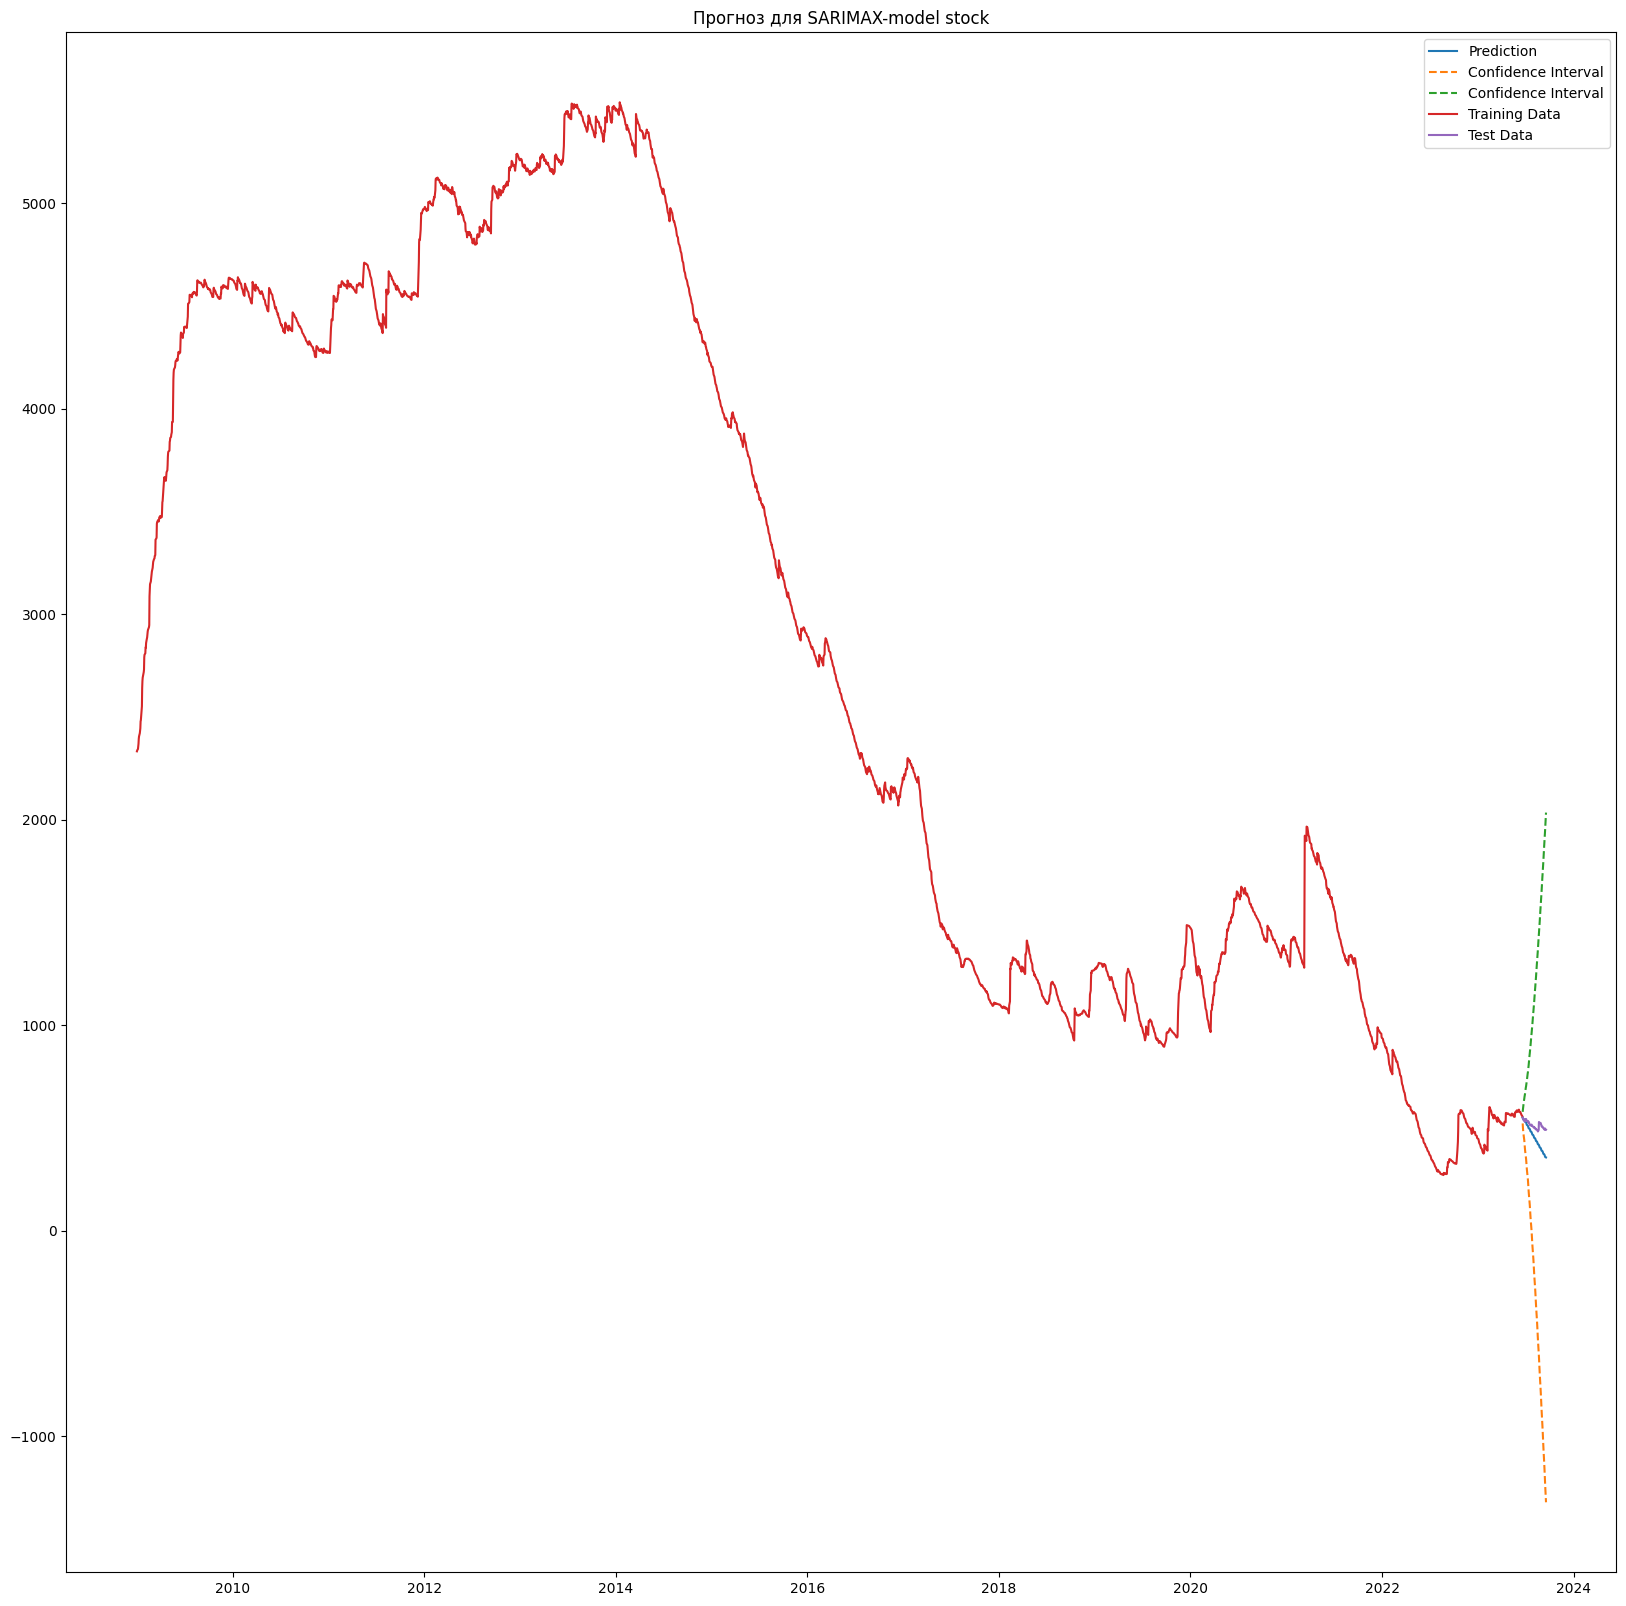

In [137]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

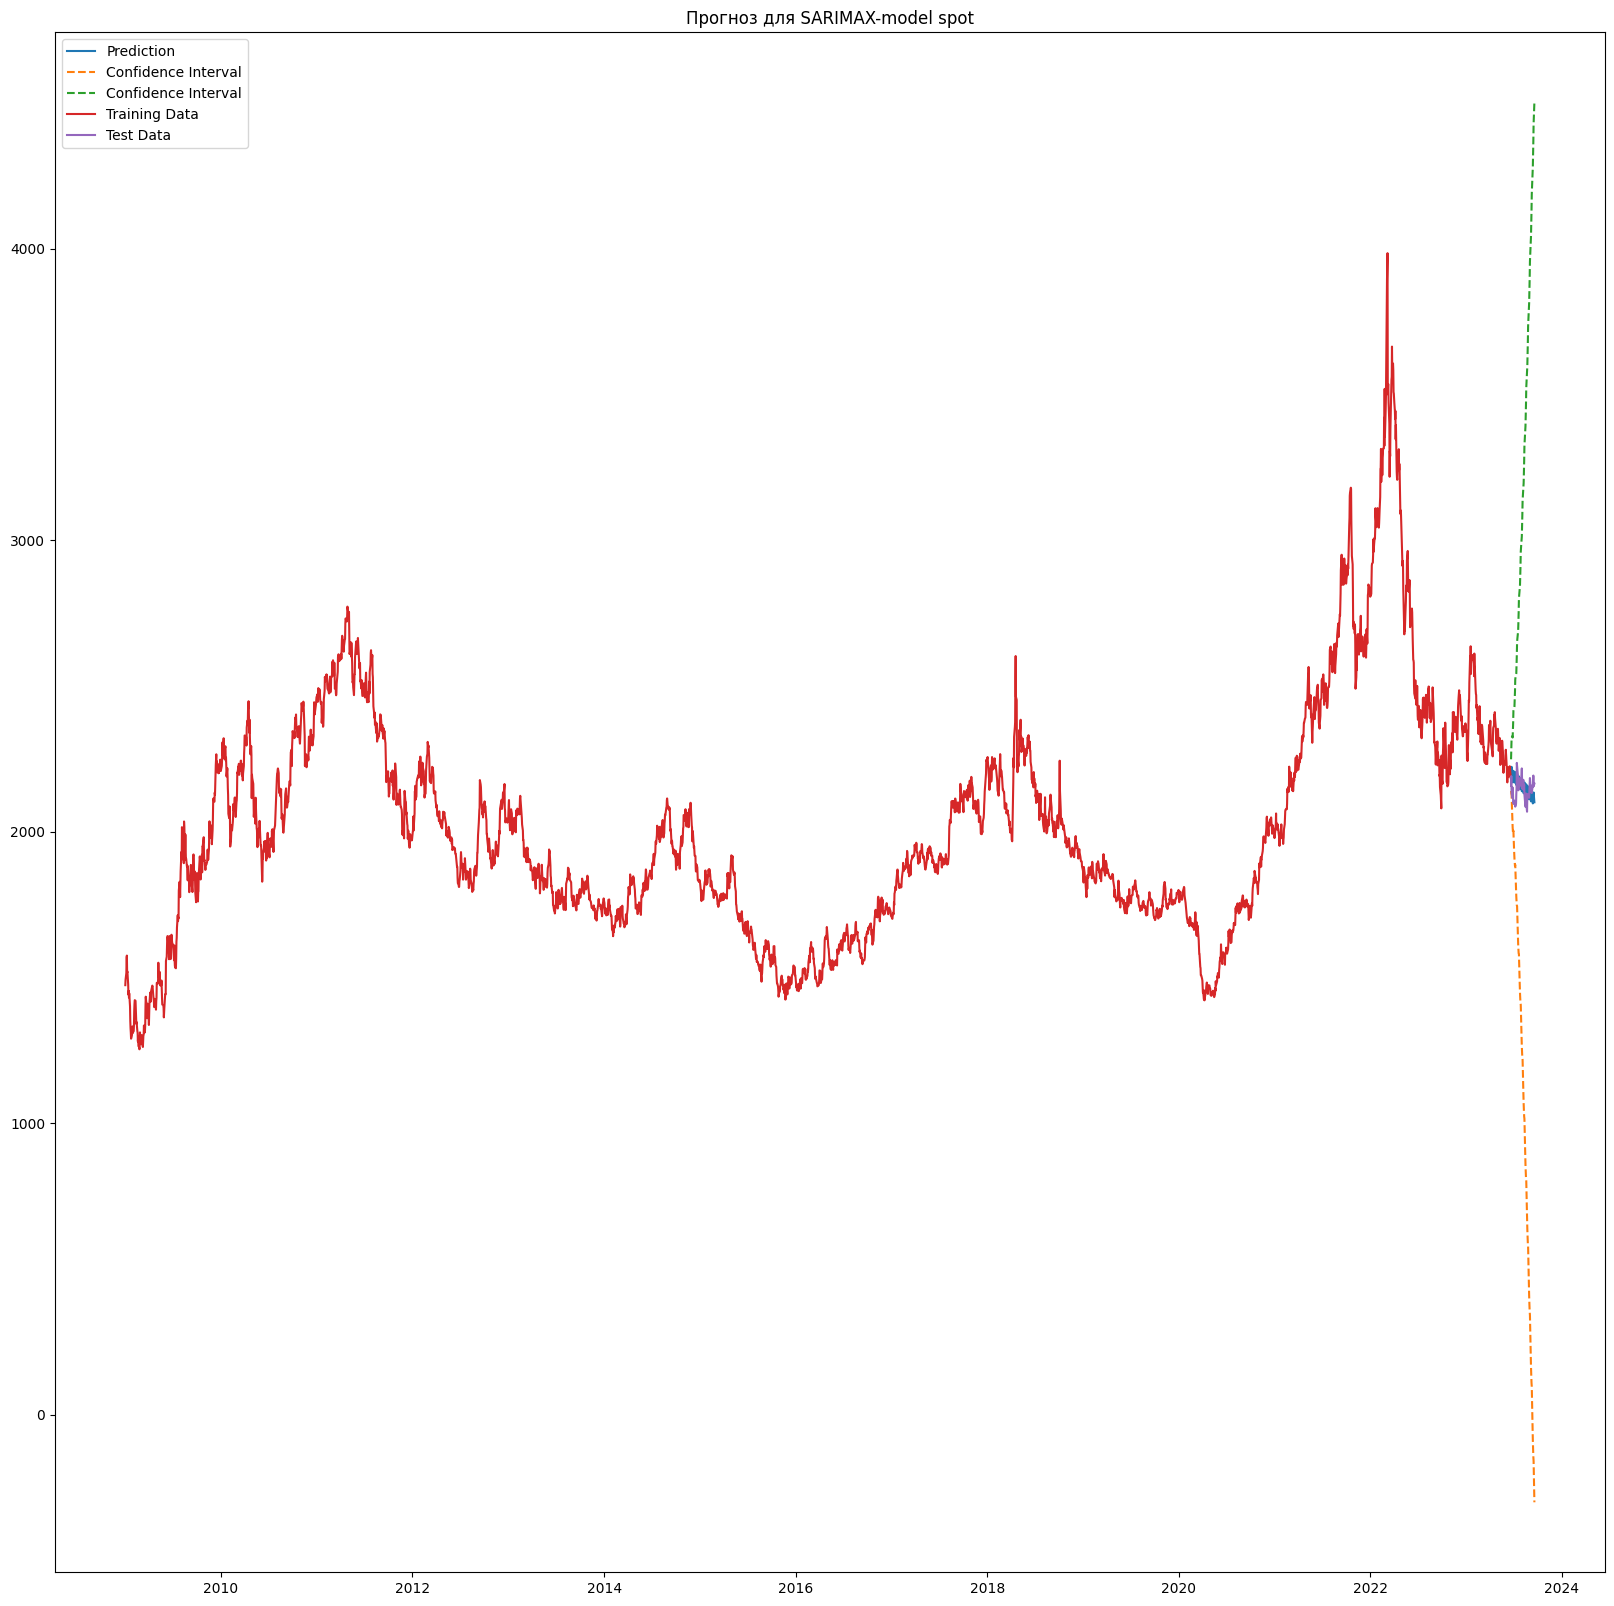

In [138]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [139]:
# Инициализируем модель
garch_stock = arch_model(train_stock, lags=1, vol='GARCH', p=1, q=1, rescale=True).fit()
garch_spot = arch_model(train_spot, lags=1, vol='GARCH', p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(start=len(train_stock), horizon=len(test_stock))
pred_garch_spot = garch_spot.forecast(start=len(train_spot), horizon=len(test_spot))

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")


Iteration:      1,   Func. Count:      6,   Neg. LLF: 50169466082.49954
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1137177499927.0864
Iteration:      3,   Func. Count:     20,   Neg. LLF: 21134023.343661636
Iteration:      4,   Func. Count:     27,   Neg. LLF: 7404389193210.715
Iteration:      5,   Func. Count:     34,   Neg. LLF: 25529.072918534643
Iteration:      6,   Func. Count:     41,   Neg. LLF: 19015.75756776869
Iteration:      7,   Func. Count:     46,   Neg. LLF: 21132.68513256589
Iteration:      8,   Func. Count:     61,   Neg. LLF: 23646.00366684665
Iteration:      9,   Func. Count:     68,   Neg. LLF: 19280.285656638378
Iteration:     10,   Func. Count:     74,   Neg. LLF: 19136.809925036483
Iteration:     11,   Func. Count:     80,   Neg. LLF: 18937.796675706875
Iteration:     12,   Func. Count:     85,   Neg. LLF: 18990.615689689585
Iteration:     13,   Func. Count:     91,   Neg. LLF: 18912.076229709295
Iteration:     14,   Func. Count:     96,   Neg. LLF: 18

> GARCH не сощелся.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [140]:
# Посмотри на лучшую модель для запасов
results = pd.read_csv('./data/errors/stock_aluminium.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-stock
Name: model_name, dtype: object

In [141]:
# И для spota
results = pd.read_csv('./data/errors/spot_aluminium.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-spot
1        SARIMAX-spot
Name: model_name, dtype: object

In [142]:
# Посмотрим на картины прогнозов для этих моделей
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-04    505.049491
2023-09-05    505.911637
2023-09-06    504.688321
2023-09-07    503.723269
2023-09-08    502.413172
2023-09-09    501.775776
2023-09-10    501.138340
2023-09-11    500.500863
2023-09-12    501.362411
2023-09-13    500.138496
2023-09-14    499.172846
2023-09-15    497.862151
2023-09-16    497.224157
2023-09-17    496.586122
2023-09-18    495.948046
Freq: D, dtype: float64

2023-09-04    553.754447
2023-09-05    553.754447
2023-09-06    553.754447
2023-09-07    553.754447
2023-09-08    553.754447
2023-09-09    553.754447
2023-09-10    553.754447
2023-09-11    553.754447
2023-09-12    553.754447
2023-09-13    553.754447
2023-09-14    553.754447
2023-09-15    553.754447
2023-09-16    553.754447
2023-09-17    553.754447
2023-09-18    553.754447
Freq: D, dtype: float64

In [143]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему 
# выбор пал на базовую модель, дело в том, что различие в метриках 
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее () 
best_ts = pred_ar_stock

In [144]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-09    501.775776
2023-09-10    501.138340
2023-09-11    500.500863
2023-09-12    501.362411
2023-09-13    500.138496
2023-09-14    499.172846
2023-09-15    497.862151
2023-09-16    497.224157
2023-09-17    496.586122
2023-09-18    495.948046
dtype: float64

In [145]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[['LME Aluminium Cash-Settlement', 'LME Aluminium 3-month']], stock_column],
    axis=1).rename(columns={0: 'LME Copper Stock'})

display(working_data.head(), working_data.tail())

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2009-01-01,1473.500000,2301.000000,2333.600000
2009-01-02,1492.000000,2285.666667,2338.300000
2009-01-03,1499.833333,2270.333333,2340.608333
2009-01-04,1507.666667,2255.000000,2342.916667
2009-01-05,1515.500000,2275.000000,2345.225000


,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-14,2192.500000,2270.000000,498.525000
2023-09-15,2155.500000,2261.666667,495.400000
2023-09-16,2158.666667,2253.333333,494.458333
2023-09-17,2161.833333,2245.000000,493.516667
2023-09-18,2165.000000,2229.000000,492.575000


In [146]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]


In [147]:
# Тренировочная эндогенная
endog_train = train.iloc[:,0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:,1:]
exog_test = test.iloc[:,1:]
#exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:,0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [148]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [149]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(start=start, end=end, exog=exog_test)

In [150]:
log_metrics_spot(metrics_calculation(pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 54.687
MAE для ARIMAX-spot: 46.107
MAPE для ARIMAX-spot: 2.1%


Дубликат значения metric. Не сохраняем.


> Вывод: Неплохой показатель, но все равно хуже чем у baseline модели

---

## Часть 2.

### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [151]:
# Сформируем трейн/тест
X_train = train.drop('LME Aluminium Cash-Settlement', axis=1)
y_train = train['LME Aluminium Cash-Settlement']

X_test = test.drop('LME Aluminium Cash-Settlement', axis=1)
y_test = test['LME Aluminium Cash-Settlement']

---

#### Linear Regression

In [152]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
log_metrics_stock(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 129.821
MAE для LR-model: 118.108
MAPE для LR-model: 5.5%


Дубликат значения metric. Не сохраняем.


---

#### Decision Tree regressor

In [153]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [154]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)
dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
log_metrics_stock(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 132.092
MAE для DT-model: 127.124
MAPE для DT-model: 6.0%


Дубликат значения metric. Не сохраняем.


---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [155]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(np.array(X_train['LME Aluminium 3-month']).reshape(-1, 1), y_train)
grid_search_srfr.best_params_

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}

In [156]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

rfr_model.fit(np.array(X_train['LME Aluminium 3-month']).reshape(-1, 1), y_train)

pred_rfr_model = rfr_model.predict(np.array(X_test['LME Aluminium 3-month']).reshape(-1, 1))
log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 117.157
MAE для RFR-model_no_stock: 95.66
MAPE для RFR-model_no_stock: 4.5%


Дубликат значения metric. Не сохраняем.


#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [157]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 300}

In [158]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 130.253
MAE для RFR-model: 125.29
MAPE для RFR-model: 5.8999999999999995%


Дубликат значения metric. Не сохраняем.


> Вывод: Как можно наблюдать, использование остатков было не плохой идеей, при том лучший результат показала модель со сформированными base-line моделью остатками, но итоговые метрики хуже чем ARIMA или AR-baseline.

----

### Stacking

In [159]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

# Определяем базовые модели для стекинга
base_models = [('LR-model', linear_regression_model), ('RandomForest', random_forest_model), ('Decision Tree', decsion_tree_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 151.187
MAE для Stacking: 142.348
MAPE для Stacking: 6.7%


Дубликат значения metric. Не сохраняем.


---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250% на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)

#### Для этого возьмем уже готовый AR прогноз и склеим с тренировочными данными, затем сгрупируем по месяцам и найдем интересующие нас показатели

---

#### Посмотрим на разброс по среднемесячным показателям

In [160]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
data = pd.read_csv('./data/aluminium.csv', index_col='date', parse_dates=['date'])
real_al = data.reset_index().groupby(pd.Grouper(key='date', freq='M')).mean()
real_al = real_al.tail(3)
real_al = real_al.reset_index()
real_al['date'] = pd.to_datetime(real_al['date'])
real_al = real_al.rename(
    columns={'date': 'Date', 'LME Aluminium Cash-Settlement': 'LME Aluminium Spot_real'})
real_al = real_al.iloc[:, :2]
real_al

,Date,LME Aluminium Spot_real
0,2023-07-31,2152.380952
1,2023-08-31,2134.159091
2,2023-09-30,2156.000000


In [161]:
final_raw = pd.concat([train_spot, pred_ar_spot]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME Aluminium Spot_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result = pd.DataFrame(final.groupby(pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result = round(result, -1)
result

,Date,LME Aluminium Spot_pred
0,2023-07-31,2180.0
1,2023-08-31,2170.0
2,2023-09-30,2170.0


In [162]:
result_table = pd.merge(left=result, right=real_al)
result_table['Delta'] = result_table['LME Aluminium Spot_pred'] - \
    result_table['LME Aluminium Spot_real']
    
result_table['Delta_%'] = (result_table['Delta']/result_table['LME Aluminium Spot_real'])*100

display(result_table)
print(f'Mean delta: {round(result_table["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table["Delta_%"].mean(),4)}')

,Date,LME Aluminium Spot_pred,LME Aluminium Spot_real,Delta,Delta_%
0,2023-07-31,2180.0,2152.380952,27.619048,1.283186
1,2023-08-31,2170.0,2134.159091,35.840909,1.679393
2,2023-09-30,2170.0,2156.000000,14.000000,0.649351


Mean delta: 25.82
Mean delta_%: 1.204


---

#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [163]:
# Расчитаем истинное среднее для квартала
real_al = data.reset_index()

real_al = real_al.rename(columns={'date': 'Date', 'LME Aluminium Cash-Settlement': 'LME Aluminium Spot_real'})

real_al['Date'] = pd.to_datetime(real_al['Date'])

real_al = real_al[
    (real_al['Date'].dt.year == 2023) &
    (real_al['Date'].dt.month.isin([7, 8, 9]))
]

real_al = real_al.iloc[:, :2]
quarter_real = round(real_al['LME Aluminium Spot_real'].mean(),4)
quarter_real 

2145.8818

In [164]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME Aluminium Spot_pred'].mean(),-1)
quarter_pred

2170.0

In [165]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

24.1182

> Вывод:

> Мы получили удовлетворительные результаты при формировании прогнозных цен. Теперь нам стоит определить механизм расчета доверительного интервала для формирования картины экономики двух состояний.

> Нам нужно определить верхнюю и нижнюю границы, это будут наши негативный и позитивный варианты (расчитать для них вероятность).

> Так же мы должны визуализировать полученные результаты для каждого из 3 прогнозируемых месяцев и для квартала.

----

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

In [166]:
# Создадим унифицированную стабильную модель
# Блок предподготовки данных
data = pd.read_csv(
    './data/aluminium.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)
data = data.resample('d').interpolate(method='linear')
data = data.iloc[:, 1]

train = data.iloc[:-90]
test = data.iloc[-90:]

In [167]:
# Подберем парамтр p
model_pmarima = pm.auto_arima(
    train, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_pmarima
p = model_pmarima.get_params()['order'][0]

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=5.13 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=55675.124, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=54123.324, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.41 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=55676.461, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=53494.206, Time=1.99 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=14.01 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=53493.802, Time=1.34 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=54121.712, Time=0.62 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=5.86 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=53494.402, Time=1.40 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=53482.469, Time=2.79 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=54103.130, Time=1.44 sec
 ARIMA(1,1,1)(2,1,1)[7]       

In [168]:
# Произведем прогноз моделью AutoReg
ar_model = AutoReg(train, lags=p, seasonal=True).fit()
pred = ar_model.predict(start=len(train), end=len(train)+len(test)-1)

In [169]:
# Создадим интервал ошибки на основе MAPE
conf_int = mean_absolute_percentage_error(test, pred).round(3)
conf_int

0.017

In [170]:
# Расчитаем вероятности ошибок на модельных месяцах
resid = (data - pd.concat([train, pred])).reset_index()
resid = resid.rename(columns={'index': 'date', 0: 'resid'})
resid['date'] = pd.to_datetime(resid['date'])
resid['year'] = resid['date'].dt.year
resid['month'] = resid['date'].dt.month
resid = resid[resid['year'] == resid['year'].max()]
months = [resid['month'].max()-2, resid['month'].max()-1, resid['month'].max()]
resid_month = resid[resid['month'].isin(months)]

# Распределение ошибок по месяцам
first_month = resid[resid['month'] == months[0]]
second_month = resid[resid['month'] == months[1]]
third_month = resid[resid['month'] == months[2]]
quart_resid = resid_month

# Вероятность приближения к верхней и нижней границе
p_up_first = round((first_month['resid'] > 0 ).sum()/len(first_month['resid']), 3)
p_down_first = round((first_month['resid'] < 0 ).sum()/len(first_month['resid']), 3)

p_up_second = round((second_month['resid'] > 0 ).sum()/len(second_month['resid']), 3)
p_down_second = round((second_month['resid'] < 0 ).sum()/len(second_month['resid']), 3)

p_up_third = round((third_month['resid'] > 0 ).sum()/len(third_month['resid']), 3)
p_down_third= round((third_month['resid'] < 0 ).sum()/len(third_month['resid']), 3)

# Вероятность приближения к верхней и нижней границе в квартале
p_up_quart = round((quart_resid['resid'] > 0 ).sum()/len(quart_resid['resid']), 3)
p_down_quart = round((quart_resid['resid'] < 0 ).sum()/len(quart_resid['resid']), 3)

# Создадим строку датафрейма
p_max = pd.DataFrame({'p_max':[p_up_first, p_up_second, p_up_third]})
p_min = pd.DataFrame({'p_min':[p_down_first, p_down_second, p_down_third]})
p_quart_max = pd.DataFrame({'p_max':[p_up_quart]})
p_quart_min = pd.DataFrame({'p_min':[p_down_quart]})

In [171]:
# Сформируем итоговую таблицу прогноза для месяцев
new_data = pd.concat([train, pred]).reset_index()
new_data = new_data.rename(columns={'index': 'date', 0: 'price'})
new_data['date'] = pd.to_datetime(new_data['date'])
month_data = new_data.groupby(pd.Grouper(key='date', freq='M')).mean()
month_data = month_data.tail(3)
month_data['max'] = month_data['price']+(month_data['price']*conf_int)
month_data['min'] = month_data['price']-(month_data['price']*conf_int)
month_data = round(month_data, -1)

# Сформируем прогнозную таблицу для месяцев
month_data.reset_index(inplace=True)
forecast_month = pd.concat([month_data, p_max, p_min], axis=1)
display(forecast_month)

,date,price,max,min,p_max,p_min
0,2023-07-31,2220.0,2260.0,2180.0,0.290,0.710
1,2023-08-31,2210.0,2250.0,2170.0,0.161,0.839
2,2023-09-30,2200.0,2240.0,2170.0,0.389,0.611


In [172]:
# Проделаем манипуляции для квартальной строки
quart_data = new_data.groupby(pd.Grouper(key='date', freq='Q')).mean().tail(1)
quart_data.reset_index(inplace=True)
quart_data['max'] = quart_data['price']+(quart_data['price']*conf_int)
quart_data['min'] = quart_data['price']-(quart_data['price']*conf_int)
quart_data = round(quart_data, -1)
forecast_quart = pd.concat([quart_data, p_quart_max, p_quart_min], axis=1)
forecast_quart['date'] = forecast_quart['date'].to_string()
forecast_quart['date'] = '3 months ahead'
display(forecast_quart)

,date,price,max,min,p_max,p_min
0,3 months ahead,2210.0,2250.0,2180.0,0.262,0.738


In [173]:
# Объединим месяцы и квартал в итоговый продукт
result = pd.concat([forecast_month, forecast_quart], axis=0).reset_index()
display(result)

,index,date,price,max,min,p_max,p_min
0,0,2023-07-31 00:00:00,2220.0,2260.0,2180.0,0.290,0.710
1,1,2023-08-31 00:00:00,2210.0,2250.0,2170.0,0.161,0.839
2,2,2023-09-30 00:00:00,2200.0,2240.0,2170.0,0.389,0.611
3,0,3 months ahead,2210.0,2250.0,2180.0,0.262,0.738


> Все отлично, но что с реальным прогнозом, сейчас мы спрогнозируем реальный 4 квартал и используем полученные вероятности приведя их к месяцу, и используем MAE для формирования доверительного интервала. Да сомнительно, но попробовать стоит.

In [174]:
# Произведем прогноз моделью AutoReg
ar_model_real = AutoReg(data, lags=p, seasonal=True).fit()
pred_real = ar_model_real.predict(start=len(data), end=len(data)+89)

In [175]:
# Сформируем итоговую таблицу прогноза для месяцев
new_data = pd.concat([train, pred_real]).reset_index()
new_data = new_data.rename(columns={'index': 'date', 0: 'price'})
new_data['date'] = pd.to_datetime(new_data['date'])
month_data = new_data.groupby(pd.Grouper(key='date', freq='M')).mean()
month_data = month_data.tail(3)
month_data['max'] = month_data['price']+(month_data['price']*conf_int)
month_data['min'] = month_data['price']-(month_data['price']*conf_int)
month_data = round(month_data, -1)

# Сформируем прогнозную таблицу для месяцев
month_data.reset_index(inplace=True)
forecast_month = pd.concat([month_data, p_max, p_min], axis=1)
display(forecast_month)

,date,price,max,min,p_max,p_min
0,2023-10-31,2200.0,2240.0,2160.0,0.290,0.710
1,2023-11-30,2190.0,2230.0,2150.0,0.161,0.839
2,2023-12-31,2180.0,2220.0,2150.0,0.389,0.611


In [176]:
# Проделаем манипуляции для квартальной строки
quart_data = new_data.groupby(pd.Grouper(key='date', freq='Q')).mean().tail(1)
quart_data.reset_index(inplace=True)
quart_data['max'] = quart_data['price']+(quart_data['price']*conf_int)
quart_data['min'] = quart_data['price']-(quart_data['price']*conf_int)
quart_data = round(quart_data, -1)
forecast_quart = pd.concat([quart_data, p_quart_max, p_quart_min], axis=1)
forecast_quart['date'] = forecast_quart['date'].to_string()
forecast_quart['date'] = '3 months ahead'
display(forecast_quart)

,date,price,max,min,p_max,p_min
0,3 months ahead,2190.0,2230.0,2160.0,0.262,0.738


In [177]:
# Объединим месяцы и квартал в итоговый продукт
result = pd.concat([forecast_month, forecast_quart], axis=0).reset_index(drop=True)
day = str(pd.to_datetime(datetime.today(), format='%Y-%m-%d'))
result.to_csv(f'./data/result_{day}_aluminium.csv', sep=',')
display(result)

,date,price,max,min,p_max,p_min
0,2023-10-31 00:00:00,2200.0,2240.0,2160.0,0.290,0.710
1,2023-11-30 00:00:00,2190.0,2230.0,2150.0,0.161,0.839
2,2023-12-31 00:00:00,2180.0,2220.0,2150.0,0.389,0.611
3,3 months ahead,2190.0,2230.0,2160.0,0.262,0.738


____

### Теперь осталось придумать как все это обернуть в один микросервис, мы должны:
### 1. Модифицировать парсер, что бы он не перезаписывал БД а добавлял дневную строку
### 2. Вывести парсер в отдельный микросервис
### 3. Развести модель которая получает вероятности и модель которая формирует интересующий нас прогноз
### 4. Написать визуализатор

___


#### Начнем с кода парсера

#### Теперь поместим его в отдельный каталог в формате .py скрипта

----